In [1]:
from hydra.utils import instantiate
from omegaconf import OmegaConf
import torch
from sgpo.models.continuous import ContinuousModel
conf = OmegaConf.load('/home/komodo/Documents/uni/thesis/sgpo/sgpo/outputs/2026-02-04/17-23-03/.hydra/config.yaml')
net = instantiate(conf.model.model, model_name=conf.pretrained_ckpt, seq_len=conf.data.seq_len, _recursive_=True)

/home/komodo/Documents/uni/thesis/active_pretraining/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/komodo/Documents/uni/thesis/active_pretraining/.env/lib/python3.10/site-packages/evodiff/pretrained.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
net: ContinuousModel
residues = list(range(conf.data.seq_len))
mask = torch.zeros(conf.data.seq_len)
mask[residues] = 1
mask = mask.to(net.device).int()
net.get_start(32).shape

infill_seed = torch.randint(0, net.model.network.vocab_size, (conf.data.seq_len,)).to(net.device)  # random seed of token ids for now
# 1 if != pad, else 0
infill_mask = (torch.ones(conf.data.seq_len) != net.tokenizer.pad_id-100).to(net.device)  # switch 30 for self.net.tokenizer.pad_id

#  changes infill_mask to only include the residues
infill_mask = infill_mask * mask

# corrupt_mask: 1 for real tokens, 0 for pad (Equivalent to "fully corrupt all real tokens")
corrupt_mask = infill_mask.clone().to(net.device)  # (B, L), 1=corrupt, 0=pad
samples = net.sample(infill_seed, infill_mask.bool(), corrupt_mask.bool(), num_samples=3)
embeds = net.get_embeds(torch.from_numpy(samples).to(net.device))
score = net.score(embeds, torch.tensor(0.5).to(net.device))
score.shape

100%|██████████| 500/500 [00:07<00:00, 62.80it/s]


torch.Size([3, 119, 480])

In [3]:
strings = [net.tokenizer.untokenize(s) for s in samples]

In [4]:
import esm

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

with torch.no_grad():
    output = model.infer_pdb(strings[0])

output

ModuleNotFoundError: No module named 'openfold'

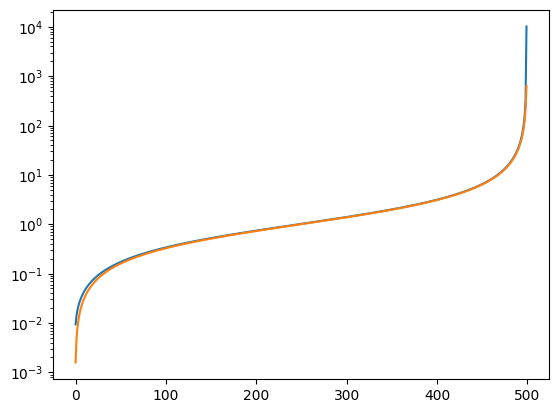

In [138]:
from matplotlib import pyplot as plt
from flowgym.schedulers import Scheduler, NoiseSchedule
from flowgym.utils import append_dims
from flowgym import FlowTensor
from torch import Tensor


class DDPMNoiseSchedule(NoiseSchedule[FlowTensor]):
    def __init__(self, scheduler: Scheduler[FlowTensor]) -> None:
        super().__init__()
        self.scheduler = scheduler
    

    def __call__(self, x: FlowTensor, t: Tensor) -> FlowTensor:
        return self.scheduler.beta(x, t) / self.scheduler.alpha(x, t)


class CosineSchedule(Scheduler[FlowTensor]):
    def __init__(self) -> None:
        super().__init__()

    def alpha(self, x: FlowTensor, t: Tensor) -> FlowTensor:
        sqrt_alpha_bar = torch.cos((1. - t) * torch.pi / 2.)
        return FlowTensor(append_dims(sqrt_alpha_bar, x.data.ndim))


    def alpha_dot(self, x: FlowTensor, t: Tensor) -> FlowTensor:
        sqrt_alpha_bar_dot = torch.pi / 2. * torch.sin((1. - t) * torch.pi / 2.)
        return FlowTensor(append_dims(sqrt_alpha_bar_dot.data, x.data.ndim))
    

    def beta(self, x: FlowTensor, t: Tensor) -> FlowTensor:
        alpha_bar = torch.cos((1. - t) * torch.pi / 2.).square()
        beta = torch.sqrt(1. - alpha_bar)
        return FlowTensor(append_dims(beta, x.data.ndim))


    def beta_dot(self, x: FlowTensor, t: Tensor) -> FlowTensor:
        alpha_bar_dot = 2. * torch.cos((1. - t) * torch.pi / 2.) * torch.pi / 2. * torch.sin((1. - t) * torch.pi / 2.)
        return -FlowTensor(alpha_bar_dot) / (2. * self.beta(x, t))


sigmas = net.noise_schedule.sigmas

sched = CosineSchedule()
x = FlowTensor(torch.zeros((len(sigmas),)))
t = torch.arange(len(sigmas)) / len(sigmas) + 0.001
t = torch.clamp(t, 0., 1.)
alphas = sched.alpha(x, t).data
our_sigmas = sched.sigma(x, t).data
betas = sched.beta(x, t).data

alpha_bar_calc = alphas.square()
test = betas / alphas
plt.plot(sigmas)
new_sigmas = DDPMNoiseSchedule(sched)(x, t).data
plt.plot(new_sigmas.flip(0))
plt.yscale('log')

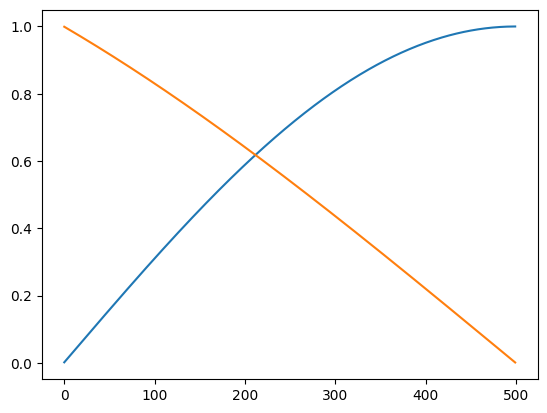

In [127]:
plt.plot(betas)
plt.plot(torch.sqrt(1. - alphas))

In [ ]:
def forward(x, t):
    